This notebook adresseses a basic single machine scheduling problem. The objective studied is minimizing total weighted number of tardy jobs. 

Each job is associated with:
- proccesing time 
- due date
- weight

A job is tardy if the completion time of job *j* is later than the due date. All jobs need to be processed on the single machine and preemption is not allowed. 

The scheduling problem can be represented by 1| | $\sum_{i=1}^n w_jU_j$. This problem is known to be NP-hard, even when the jobs all have common due date. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle such detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the code. 



In [1]:
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 

In [2]:
minProcessingTime=10
maxProcessingTime=40
import random
processingTimes = [random.randint(minProcessingTime, maxProcessingTime) for j in jobs]

In [3]:
minDueDate=75
maxDueDate=200
dueDates = random.sample(range(minDueDate, maxDueDate), len(jobs))

In [4]:
minWeight=1
maxWeight=5
weights = [random.randint(minWeight, maxWeight) for j in jobs]

In [5]:
import pandas as pd
JobsTable = pd.DataFrame(columns=['job', 'processing_time', 'weight', 'due_date'])
for j in jobs:
    JobsTable=JobsTable.append({'job': j,'processing_time':processingTimes[j],'weight':weights[j],'due_date':dueDates[j]}, ignore_index=True)
print(JobsTable)

  job processing_time weight due_date
0   0              36      1       96
1   1              12      4      107
2   2              25      3       87
3   3              15      1      158
4   4              13      2       88
5   5              37      1       78
6   6              23      1      150
7   7              15      2       89
8   8              36      4       77
9   9              15      5      171


In [6]:
from docplex.cp.model import *
mdl = CpoModel(name='singleMachineScheduling_WeightedNbrOfTardyJobs') 

In [7]:
# define production processing interval of each job at each machine
processing_itv_vars = [mdl.interval_var(size=processingTimes[j], name="interval_job{}".format(j)) for j in jobs] 
for j in jobs:
    print(processing_itv_vars[j])

interval_job0 = intervalVar(size=36)
interval_job1 = intervalVar(size=12)
interval_job2 = intervalVar(size=25)
interval_job3 = intervalVar(size=15)
interval_job4 = intervalVar(size=13)
interval_job5 = intervalVar(size=37)
interval_job6 = intervalVar(size=23)
interval_job7 = intervalVar(size=15)
interval_job8 = intervalVar(size=36)
interval_job9 = intervalVar(size=15)


In [8]:
#minimize number of tardy jobs
objective = mdl.sum((mdl.end_of(processing_itv_vars[j])>dueDates[j])*weights[j] for j in jobs)  
mdl.add(mdl.minimize(objective)) 

In [9]:
#No overlap constraint
mdl.add(mdl.no_overlap([processing_itv_vars[j] for j in jobs])) 

In [10]:
msol= mdl.solve(log_output=True)

In [11]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 0, interval: 10, sequence: 1
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.46 sec
-------------------------------------------------------------------------------
Objective values: (2,), bounds: (2,), gaps: (0,)
interval_job0: (start=154, end=190, size=36, length=36)
interval_job1: (start=89, end=101, size=12, length=12)
interval_job2: (start=13, end=38, size=25, length=25)
interval_job3: (start=139, end=154, size=15, length=15)
interval_job4: (start=0, end=13, size=13, length=13)
interval_job5: (start=190, end=227, size=37, length=37)
interval_job6: (start=116, end=139, size=23, length=23)
interval_job7: (start=74, end=89, size=15, length=15)
interval_job8: (start=38, end=74, size=36, length=36)
interval_job9: (start=101, end=116, size=15, length=15)


In [12]:
for j in jobs:
    if((msol.get_var_solution(processing_itv_vars[j]).get_end()) > dueDates[j]):
       print("job {} with weight {} is tardy".format(j,weights[j]))
    

job 0 with weight 1 is tardy
job 5 with weight 1 is tardy


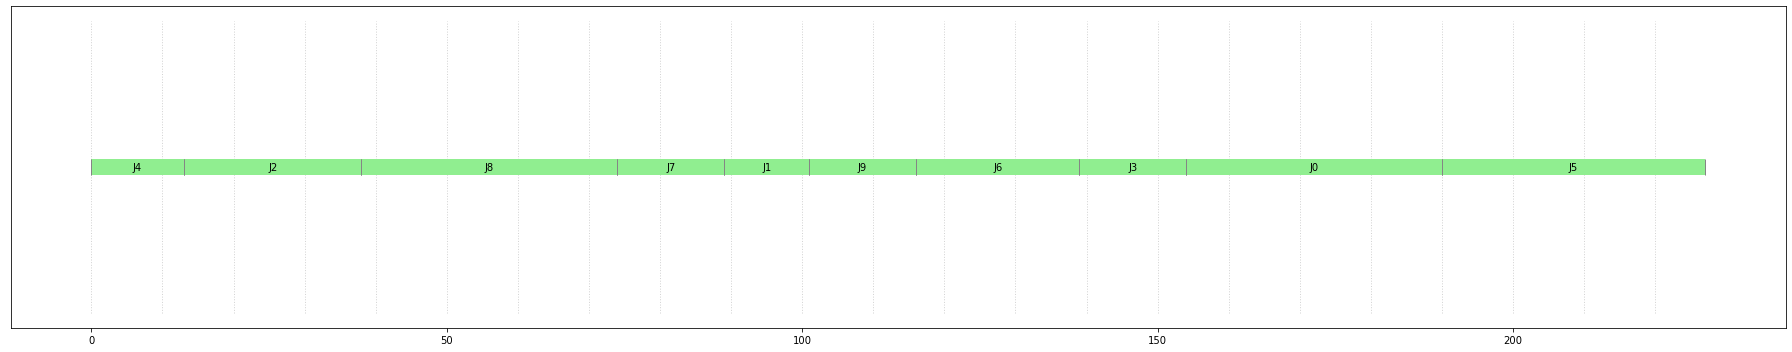

In [13]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for j in jobs:
        itv = msol.get_var_solution(processing_itv_vars[j])
        if itv.is_present():
            visu.interval(itv,'lightgreen','J' + str(j))
    visu.show()